# Diamond analysis

## importing libraries

In [13]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import matplotlib.pyplot as plt

## reading data

In [14]:
dataset = pd.read_csv('data/messy_data.csv', skipinitialspace=True)

# Print the size of the messy data
print('Size of messy data: %d' % len(dataset))

# Print column names
print('Column names: %s' % list(dataset.columns))

Size of messy data: 200
Column names: ['carat', 'clarity', 'color', 'cut', 'x dimension', 'y dimension', 'z dimension', 'depth', 'table', 'price']


## Data cleaning

### initial cleaning

In [15]:
# Strip leading/trailing spaces from column names
dataset.columns = dataset.columns.str.strip()

# clarity, color and cut should be uppercase
dataset['clarity'] = dataset['clarity'].str.upper()
dataset['color'] = dataset['color'].str.upper()
dataset['cut'] = dataset['cut'].str.upper()

# Rename columns x dimension, y dimension, and z dimension to length, width, and height
dataset = dataset.rename(columns={'x dimension': 'length', 'y dimension': 'width', 'z dimension': 'height'})

# Drop rows with missing price values
dataset.dropna(subset=['price'], inplace=True)

# Drop any duplicate rows
dataset.drop_duplicates(inplace=True)

# Print the size of the messy data
print('Size of data: %d' % len(dataset))

# Print column names
print('Column names: %s' % list(dataset.columns))

Size of data: 196
Column names: ['carat', 'clarity', 'color', 'cut', 'length', 'width', 'height', 'depth', 'table', 'price']


### write clean data to csv

In [16]:
# We do not want to deal with missing values yet
clean_data = dataset.copy()
clean_data.to_csv('data/clean_data.csv', index=False)

### identifying missing data

In [17]:

missingValues = dataset.isnull().sum()
print("Missing values: \n", missingValues, "\n")

print("In total, there were", missingValues.sum(), "missing values in the dataset.", "\n")

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')

# Fit on columns: carat, length, width, height, depth, and table
imputer.fit(dataset[['carat', 'length', 'width', 'height', 'depth', 'table']])

# Transform columns: carat, length, width, height, depth, and table
dataset[['carat', 'length', 'width', 'height', 'depth', 'table']] = imputer.transform(dataset[['carat', 'length', 'width', 'height', 'depth', 'table']])

print("After imputation, there are", dataset.isnull().sum().sum(), "missing values in the dataset.")



Missing values: 
 carat      48
clarity     0
color       0
cut         0
length      2
width      64
height     46
depth      67
table      32
price       0
dtype: int64 

In total, there were 259 missing values in the dataset. 

After imputation, there are 0 missing values in the dataset.


### Remove extreme values

In [18]:
for col in ['price']:
    lower_bound, upper_bound = dataset[col].quantile(0.05), dataset[col].quantile(0.95)
    dataset = dataset[(dataset[col] >= lower_bound) & (dataset[col] <= upper_bound)]

print("dataset size after removing outliers:", dataset.shape)

dataset size after removing outliers: (178, 10)


## Regression model

### One-hot encoding

In [19]:
categorical_vars = ['clarity', 'color', 'cut']

ct = ColumnTransformer([("encoder", OneHotEncoder(), categorical_vars)], remainder='passthrough')
df_encoded = ct.fit_transform(dataset)

encoded_columns = ct.get_feature_names_out()[:-7]
non_categorical_columns = [col for col in dataset.columns if col not in categorical_vars]
new_columns = np.append(encoded_columns, non_categorical_columns)

dataset = pd.DataFrame(df_encoded, columns=new_columns)

### Split the features and dependent variable

In [20]:
X = dataset.drop('price', axis=1)
y = dataset['price']

y.to_csv('data/model_expected_data.csv', index=False)

### Backwards elimination

In [21]:
def backward_elimination(data, target, significance_level=0.05):
    features = data.columns.tolist()
    while len(features) > 0:
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:] 
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features


selected_features = backward_elimination(X, y)
print(selected_features)

# Print the significance of each feature
summary = sm.OLS(y, sm.add_constant(X[selected_features])).fit().summary()
print(summary)



['encoder__clarity_I1', 'encoder__clarity_IF', 'encoder__clarity_SI1', 'encoder__clarity_SI2', 'encoder__clarity_VVS1', 'encoder__clarity_VVS2', 'encoder__color_COLORLESS', 'encoder__color_D', 'encoder__color_E', 'encoder__color_F', 'encoder__color_G', 'encoder__color_H', 'encoder__color_I', 'encoder__color_J', 'encoder__cut_FAIR', 'encoder__cut_GOOD', 'encoder__cut_IDEAL', 'encoder__cut_PREMIUM', 'encoder__cut_VERY GOOD', 'carat', 'length']
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     74.68
Date:                Sat, 03 Feb 2024   Prob (F-statistic):           6.97e-68
Time:                        23:13:25   Log-Likelihood:                -1472.7
No. Observations:                 178   AIC:                             2983.
D

### Building the model

In [22]:
X_selected = X[selected_features]
# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=1)
X_selected.to_csv('data/model_train_data.csv', index=False)

model = LinearRegression()
# model.fit(X_train, y_train)
model.fit(X_selected, y)

# Save the model to a file
import joblib
joblib.dump(model, 'model.joblib')

['model.joblib']

### Rate the model

In [23]:
y_pred = model.predict(X_selected)
print('RMSE:', mean_squared_error(y, y_pred) ** 0.5)
print('R^2:', r2_score(y, y_pred))

RMSE: 990.7750229327623
R^2: 0.8845736739470954


### Visualize the results

min(y): 1400.0, max(y): 10700.0
min(y_pred): 128.0, max(y_pred): 10368.0


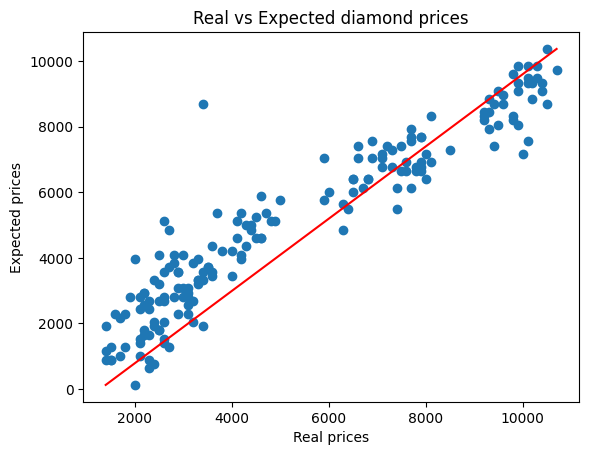

In [24]:
plt.scatter(y, y_pred)
plt.xlabel('Real prices')
plt.ylabel('Expected prices')
plt.title('Real vs Expected diamond prices')
plt.plot([min(y), max(y)], [min(y_pred), max(y_pred)], color='red')
print(f'min(y): {min(y)}, max(y): {max(y)}')
print(f'min(y_pred): {min(y_pred)}, max(y_pred): {max(y_pred)}')
plt.show()